<a href="https://colab.research.google.com/github/hariniramalingam2320-beep/actigraphy-depression-modeling/blob/main/actigraphy_depression_full_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
#Phase 0: Upload & unzip data
from google.colab import files
import os
import zipfile
import numpy as np

zip_path = "depression_actigraphy.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("data")

print("Dataset extracted to 'data/'")


for root, dirs, files in os.walk("data"):
    level = root.replace("data", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files:
        print(f"{indent}  {f}")


Dataset extracted to 'data/'
data/
  data/
    scores.csv
    control/
      control_27.csv
      control_1.csv
      control_15.csv
      control_11.csv
      control_28.csv
      control_30.csv
      control_9.csv
      control_12.csv
      control_4.csv
      control_17.csv
      control_2.csv
      control_6.csv
      control_8.csv
      control_22.csv
      control_24.csv
      control_3.csv
      control_5.csv
      control_31.csv
      control_18.csv
      control_32.csv
      control_25.csv
      control_26.csv
      control_7.csv
      control_14.csv
      control_13.csv
      control_23.csv
      control_29.csv
      control_16.csv
      control_21.csv
      control_20.csv
      control_10.csv
      control_19.csv
    condition/
      condition_12.csv
      condition_7.csv
      condition_4.csv
      condition_2.csv
      condition_22.csv
      condition_17.csv
      condition_11.csv
      condition_8.csv
      condition_15.csv
      condition_16.csv
      condition_18.csv
  

In [10]:
## Phase 1: Data Loading
import pandas as pd

CONTROL_DIR = "data/data/control"
CONDITION_DIR = "data/data/condition"
SCORES_FILE = "data/data/scores.csv"

def load_actigraphy(folder, group_label):
    dfs = []
    for file in sorted(os.listdir(folder)):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder, file))
            df["participant_id"] = file.replace(".csv", "")
            df["group"] = group_label
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

control_data = load_actigraphy(CONTROL_DIR, "control")
condition_data = load_actigraphy(CONDITION_DIR, "condition")

actigraphy_data = pd.concat([control_data, condition_data], ignore_index=True)

actigraphy_data["timestamp"] = pd.to_datetime(actigraphy_data["timestamp"])
actigraphy_data["date"] = pd.to_datetime(actigraphy_data["date"])
actigraphy_data.head()


,timestamp,date,activity,participant_id,group
0,2003-03-18 15:00:00,2003-03-18,60,control_1,control
1,2003-03-18 15:01:00,2003-03-18,0,control_1,control
2,2003-03-18 15:02:00,2003-03-18,264,control_1,control
3,2003-03-18 15:03:00,2003-03-18,662,control_1,control
4,2003-03-18 15:04:00,2003-03-18,293,control_1,control


In [26]:
## Phase 2: Data Quality Control
# Step 2.1: Basic structure check
actigraphy_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571706 entries, 0 to 1571705
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   timestamp       1571706 non-null  datetime64[ns]
 1   date            1571706 non-null  datetime64[ns]
 2   activity        1571706 non-null  int64         
 3   participant_id  1571706 non-null  object        
 4   group           1571706 non-null  object        
 5   hour            1571706 non-null  int32         
 6   day             1571706 non-null  object        
 7   is_daytime      1571706 non-null  bool          
dtypes: bool(1), datetime64[ns](2), int32(1), int64(1), object(3)
memory usage: 79.4+ MB


In [12]:
#step 2.2: Number of participants per group
actigraphy_data.groupby("group")["participant_id"].nunique()


,participant_id
group,
condition,23
control,32


In [13]:
#step 2.3: Recording duration per participant
duration = (
    actigraphy_data
    .groupby("participant_id")
    .agg(
        start_time=("timestamp", "min"),
        end_time=("timestamp", "max"),
        n_minutes=("timestamp", "count")
    )
)

duration.head()


,start_time,end_time,n_minutes
participant_id,,,
condition_1,2003-05-07 12:00:00,2003-05-23 15:23:00,23244
condition_10,2004-08-31 09:00:00,2004-09-15 08:14:00,21555
condition_11,2004-09-28 09:30:00,2004-10-14 08:39:00,22990
condition_12,2005-03-08 10:00:00,2005-03-23 19:06:00,22147
condition_13,2005-08-11 09:00:00,2005-08-29 08:49:00,25910


In [14]:
#step 2.4: Distribution of recording lengths
duration["n_minutes"].describe()


,n_minutes
count,55.000000
mean,28576.472727
std,10711.258367
min,19299.000000
25%,21662.000000
50%,23244.000000
75%,31479.000000
max,65407.000000


In [15]:
#step 2.5:Time resolution check (CRITICAL)
def time_resolution(df):
    diffs = df.sort_values("timestamp")["timestamp"].diff().dropna()
    return diffs.value_counts().head(3)

actigraphy_data.groupby("participant_id").apply(time_resolution).head()


/tmp/ipython-input-2226748356.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  actigraphy_data.groupby("participant_id").apply(time_resolution).head()


,,count
participant_id,timestamp,
condition_1,0 days 00:01:00,23243
condition_10,0 days 00:01:00,21554
condition_11,0 days 00:01:00,22989
condition_12,0 days 00:01:00,22146
condition_13,0 days 00:01:00,25909


In [16]:
#step 2.6: Missing minute detection
def missing_minutes(df):
    full_range = pd.date_range(df["timestamp"].min(),
                               df["timestamp"].max(),
                               freq="1min")
    return len(full_range) - len(df)

missing_summary = (
    actigraphy_data
    .groupby("participant_id")
    .apply(missing_minutes)
    .reset_index(name="missing_minutes")
)

missing_summary.describe()


/tmp/ipython-input-2365037135.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(missing_minutes)


,missing_minutes
count,55.000000
mean,5.454545
std,17.407766
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,60.000000


In [17]:
#step 2.7: Activity value sanity check
actigraphy_data["activity"].describe()


,activity
count,1.571706e+06
mean,1.795652e+02
std,3.597233e+02
min,0.000000e+00
25%,0.000000e+00
50%,4.000000e+00
75%,2.020000e+02
max,8.000000e+03


In [18]:
#step 2.8: Zero-activity proportion
 (actigraphy_data["activity"] == 0).mean()


np.float64(0.4199882166257557)

In [22]:
## Phase 3: Feature Extraction
##step 3.1:Create time-derived columns
actigraphy_data["hour"] = actigraphy_data["timestamp"].dt.hour
actigraphy_data["day"] = actigraphy_data["timestamp"].dt.date
# step 3.2: Define day vs night (standard definition)
actigraphy_data["is_daytime"] = actigraphy_data["hour"].between(7, 22)
# step 3.3:Basic activity statistics (per participant)
basic_features = (
    actigraphy_data
    .groupby("participant_id")["activity"]
    .agg(
        mean_activity="mean",
        median_activity="median",
        std_activity="std",
        var_activity="var",
        min_activity="min",
        max_activity="max"
    )
    .reset_index()
)

basic_features.head()



,participant_id,mean_activity,median_activity,std_activity,var_activity,min_activity,max_activity
0,condition_1,146.948030,9.0,294.592424,86784.696176,0,3526
1,condition_10,289.647228,103.0,406.604472,165327.196507,0,4935
2,condition_11,129.383036,0.0,284.535406,80960.397363,0,3506
3,condition_12,151.444846,13.0,273.993798,75072.601074,0,3622
4,condition_13,221.348746,36.0,347.336033,120642.319608,0,4859


In [23]:
#step 3.4:Zero-activity proportion
zero_activity = (
    actigraphy_data
    .assign(is_zero=lambda x: x["activity"] == 0)
    .groupby("participant_id")["is_zero"]
    .mean()
    .reset_index(name="zero_activity_ratio")
)

zero_activity.head()



,participant_id,zero_activity_ratio
0,condition_1,0.469024
1,condition_10,0.362143
2,condition_11,0.569682
3,condition_12,0.451844
4,condition_13,0.432574


In [27]:
# step 3.5: Day–night activity ratio
day_night_activity = (
    actigraphy_data
    .groupby(["participant_id", "is_daytime"])["activity"]
    .mean()
    .unstack()
    .reset_index()
)

day_night_activity.columns = ["participant_id", "night_activity", "day_activity"]

# Avoid division errors
day_night_activity["day_night_ratio"] = (
    day_night_activity["day_activity"] /
    day_night_activity["night_activity"].replace(0, np.nan)
)

day_night_activity.head()


,participant_id,night_activity,day_activity,day_night_ratio
0,condition_1,20.753125,209.218453,10.081299
1,condition_10,29.464583,420.146360,14.259369
2,condition_11,63.104818,162.630372,2.577147
3,condition_12,43.968333,203.216498,4.621883
4,condition_13,86.337731,288.893341,3.346084


In [28]:
#step 3.6: Intradaily Variability
def intradaily_variability(activity_series):
    diff = np.diff(activity_series)
    return np.mean(diff**2) / np.var(activity_series)

iv_feature = (
    actigraphy_data
    .groupby("participant_id")["activity"]
    .apply(intradaily_variability)
    .reset_index(name="intradaily_variability")
)

iv_feature.head()


,participant_id,intradaily_variability
0,condition_1,0.438656
1,condition_10,0.461629
2,condition_11,0.412332
3,condition_12,0.509732
4,condition_13,0.535756


In [29]:
#step 3.7: Relative Amplitude (RA)
def relative_amplitude(df):
    day = df[df["is_daytime"]]["activity"].mean()
    night = df[~df["is_daytime"]]["activity"].mean()
    return (day - night) / (day + night)

ra_feature = (
    actigraphy_data
    .groupby("participant_id")
    .apply(relative_amplitude)
    .reset_index(name="relative_amplitude")
)

ra_feature.head()


/tmp/ipython-input-906889112.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(relative_amplitude)


,participant_id,relative_amplitude
0,condition_1,0.819516
1,condition_10,0.868933
2,condition_11,0.440895
3,condition_12,0.644247
4,condition_13,0.539816


In [30]:
#Step 3.8: Combine all features
features = (
    basic_features
    .merge(zero_activity, on="participant_id")
    .merge(day_night_activity[["participant_id", "day_night_ratio"]], on="participant_id")
    .merge(iv_feature, on="participant_id")
    .merge(ra_feature, on="participant_id")
)

features.head()


,participant_id,mean_activity,median_activity,std_activity,var_activity,min_activity,max_activity,zero_activity_ratio,day_night_ratio,intradaily_variability,relative_amplitude
0,condition_1,146.948030,9.0,294.592424,86784.696176,0,3526,0.469024,10.081299,0.438656,0.819516
1,condition_10,289.647228,103.0,406.604472,165327.196507,0,4935,0.362143,14.259369,0.461629,0.868933
2,condition_11,129.383036,0.0,284.535406,80960.397363,0,3506,0.569682,2.577147,0.412332,0.440895
3,condition_12,151.444846,13.0,273.993798,75072.601074,0,3622,0.451844,4.621883,0.509732,0.644247
4,condition_13,221.348746,36.0,347.336033,120642.319608,0,4859,0.432574,3.346084,0.535756,0.539816


In [31]:
#step 3.9: Add group labels
group_labels = (
    actigraphy_data
    .groupby("participant_id")["group"]
    .first()
    .reset_index()
)

features = features.merge(group_labels, on="participant_id")
features.head()


,participant_id,mean_activity,median_activity,std_activity,var_activity,min_activity,max_activity,zero_activity_ratio,day_night_ratio,intradaily_variability,relative_amplitude,group
0,condition_1,146.948030,9.0,294.592424,86784.696176,0,3526,0.469024,10.081299,0.438656,0.819516,condition
1,condition_10,289.647228,103.0,406.604472,165327.196507,0,4935,0.362143,14.259369,0.461629,0.868933,condition
2,condition_11,129.383036,0.0,284.535406,80960.397363,0,3506,0.569682,2.577147,0.412332,0.440895,condition
3,condition_12,151.444846,13.0,273.993798,75072.601074,0,3622,0.451844,4.621883,0.509732,0.644247,condition
4,condition_13,221.348746,36.0,347.336033,120642.319608,0,4859,0.432574,3.346084,0.535756,0.539816,condition


In [32]:
#step 3.10: Final feature table check
features.info()
features.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   participant_id          55 non-null     object 
 1   mean_activity           55 non-null     float64
 2   median_activity         55 non-null     float64
 3   std_activity            55 non-null     float64
 4   var_activity            55 non-null     float64
 5   min_activity            55 non-null     int64  
 6   max_activity            55 non-null     int64  
 7   zero_activity_ratio     55 non-null     float64
 8   day_night_ratio         55 non-null     float64
 9   intradaily_variability  55 non-null     float64
 10  relative_amplitude      55 non-null     float64
 11  group                   55 non-null     object 
dtypes: float64(8), int64(2), object(2)
memory usage: 5.3+ KB


,mean_activity,median_activity,std_activity,var_activity,min_activity,max_activity,zero_activity_ratio,day_night_ratio,intradaily_variability,relative_amplitude
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,189.862636,28.890909,340.559636,125758.470446,0.054545,4834.345455,0.404109,4.706817,0.455740,0.587394
std,80.547674,38.088432,99.793145,72031.367032,0.404520,1700.860776,0.179880,2.578967,0.095910,0.176544
min,54.697992,0.000000,136.137517,18533.423626,0.000000,1355.000000,0.000000,0.988402,0.267964,-0.005833
25%,142.301726,0.000000,285.130952,81299.924093,0.000000,3574.000000,0.323280,3.345659,0.387713,0.539771
50%,172.288577,9.000000,330.801716,109429.775491,0.000000,4609.000000,0.415773,4.141922,0.461629,0.611040
75%,243.378252,47.500000,412.005029,169758.685194,0.000000,6024.000000,0.512793,5.098150,0.506903,0.672027
max,398.883456,141.000000,624.376553,389846.080502,3.000000,8000.000000,0.805204,14.259369,0.827402,0.868933


In [34]:
## Phase 4: Clinical Data Integration and Modeling Setup
# step 4.1: Load clinical metadata
scores = pd.read_csv("data/data/scores.csv")
scores.head()


,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [35]:
#step 4.2 Inspect clinical data structure
scores.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   number     55 non-null     object 
 1   days       55 non-null     int64  
 2   gender     55 non-null     int64  
 3   age        55 non-null     object 
 4   afftype    23 non-null     float64
 5   melanch    20 non-null     float64
 6   inpatient  23 non-null     float64
 7   edu        53 non-null     object 
 8   marriage   23 non-null     float64
 9   work       23 non-null     float64
 10  madrs1     23 non-null     float64
 11  madrs2     23 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 5.3+ KB


In [38]:
#step 4.3: Rename ID column for merging
scores = scores.rename(columns={"number": "participant_id"})


In [37]:
#step 4.4: Merge actigraphy features with clinical data
data = features.merge(scores, on="participant_id", how="left")
data.head()


,participant_id,mean_activity,median_activity,std_activity,var_activity,min_activity,max_activity,zero_activity_ratio,day_night_ratio,intradaily_variability,...,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,146.948030,9.0,294.592424,86784.696176,0,3526,0.469024,10.081299,0.438656,...,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_10,289.647228,103.0,406.604472,165327.196507,0,4935,0.362143,14.259369,0.461629,...,2,45-49,2.0,2.0,2.0,6-10,1.0,2.0,28.0,21.0
2,condition_11,129.383036,0.0,284.535406,80960.397363,0,3506,0.569682,2.577147,0.412332,...,1,45-49,2.0,2.0,2.0,6-10,1.0,2.0,24.0,24.0
3,condition_12,151.444846,13.0,273.993798,75072.601074,0,3622,0.451844,4.621883,0.509732,...,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,25.0,21.0
4,condition_13,221.348746,36.0,347.336033,120642.319608,0,4859,0.432574,3.346084,0.535756,...,2,35-39,1.0,2.0,2.0,11-15,2.0,2.0,18.0,13.0


In [40]:
#step 4.5: Verify merge integrity
data.shape
data.isna().sum()



,0
participant_id,0
mean_activity,0
median_activity,0
std_activity,0
var_activity,0
min_activity,0
max_activity,0
zero_activity_ratio,0
day_night_ratio,0
intradaily_variability,0


In [43]:
#step 4.6: Define modeling targets
data["condition_label"] = (data["group"] == "condition").astype(int)
data["madrs1"]



,madrs1
0,19.0
1,28.0
2,24.0
3,25.0
4,18.0
5,28.0
6,14.0
7,13.0
8,17.0
9,18.0


In [44]:
#step 4.7: Select feature columns
feature_cols = [
    "mean_activity",
    "median_activity",
    "std_activity",
    "var_activity",
    "zero_activity_ratio",
    "day_night_ratio",
    "intradaily_variability",
    "relative_amplitude"
]


In [45]:
#step 4.8: Create modeling datasets
X_classification = data[feature_cols]
y_classification = data["condition_label"]
regression_data = data[data["group"] == "condition"].copy()

X_regression = regression_data[feature_cols]
y_regression = regression_data["madrs1"]


In [46]:
#step 4.9: Final sanity checks
X_classification.shape, y_classification.shape
X_regression.shape, y_regression.shape


((23, 8), (23,))

In [47]:
## Phase 5: Modeling
#step 5.1: Imports for modeling
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score, make_scorer


In [48]:
#step 5.2: Classification task (Control vs Condition)
clf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc = cross_val_score(
    clf_pipeline,
    X_classification,
    y_classification,
    cv=cv,
    scoring="roc_auc"
)

roc_auc
roc_auc.mean(), roc_auc.std()


(np.float64(0.700952380952381), np.float64(0.1916191896241072))

In [49]:
#step 5.3: Regression task (MADRS severity)
reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])
r2_scores = cross_val_score(
    reg_pipeline,
    X_regression,
    y_regression,
    cv=5,
    scoring="r2"
)

r2_scores
r2_scores.mean(), r2_scores.std()


(np.float64(-5.900086444866204), np.float64(10.513476061301185))

In [52]:
#step 5.4:Fit models to inspect coefficients
clf_pipeline.fit(X_classification, y_classification)



Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=1000))])

In [53]:
coef_clf = pd.Series(
    clf_pipeline.named_steps["clf"].coef_[0],
    index=feature_cols
).sort_values()

coef_clf


,0
median_activity,-0.744671
relative_amplitude,-0.361644
std_activity,-0.214642
var_activity,-0.090301
zero_activity_ratio,0.000892
mean_activity,0.159492
day_night_ratio,0.813778
intradaily_variability,0.831509


In [54]:
reg_pipeline.fit(X_regression, y_regression)


Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())])

In [55]:
coef_reg = pd.Series(
    reg_pipeline.named_steps["ridge"].coef_,
    index=feature_cols
).sort_values()

coef_reg


,0
intradaily_variability,-1.660623
std_activity,-1.463416
var_activity,-1.047803
relative_amplitude,-0.236782
day_night_ratio,-0.098328
zero_activity_ratio,0.506285
median_activity,1.261009
mean_activity,1.419560


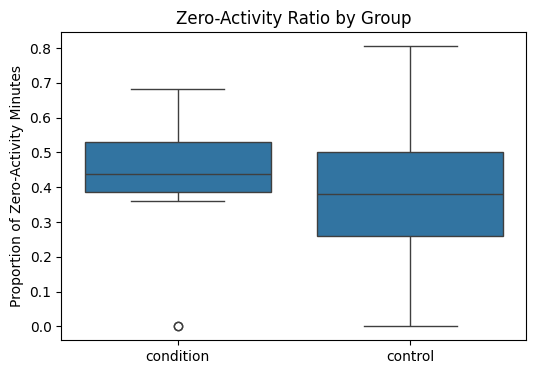

In [57]:
## Phase 6: Interpretation and Visualization
#step 6.1: Visualize feature distributions (Control vs Condition)
#Plot 1 — Zero activity ratio
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x="group", y="zero_activity_ratio")
plt.title("Zero-Activity Ratio by Group")
plt.ylabel("Proportion of Zero-Activity Minutes")
plt.xlabel("")
plt.show()



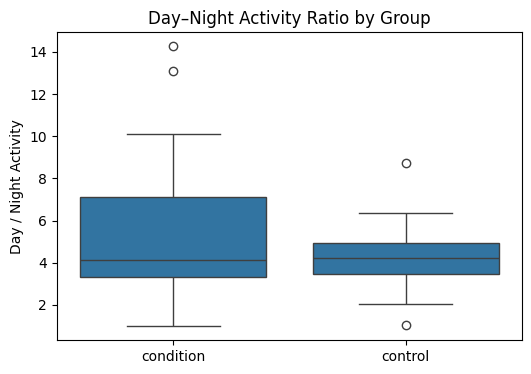

In [58]:
#plot 2- Day–night activity ratio
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x="group", y="day_night_ratio")
plt.title("Day–Night Activity Ratio by Group")
plt.ylabel("Day / Night Activity")
plt.xlabel("")
plt.show()


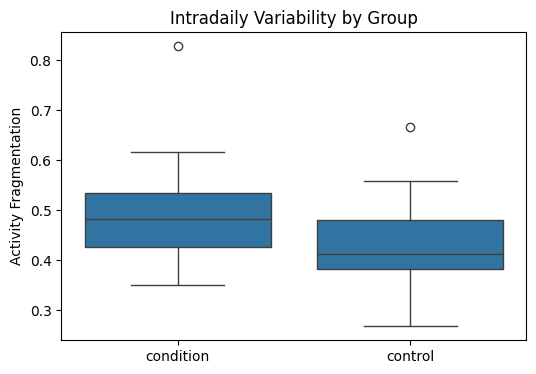

In [59]:
#Plot 3: Intradaily variability
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x="group", y="intradaily_variability")
plt.title("Intradaily Variability by Group")
plt.ylabel("Activity Fragmentation")
plt.xlabel("")
plt.show()


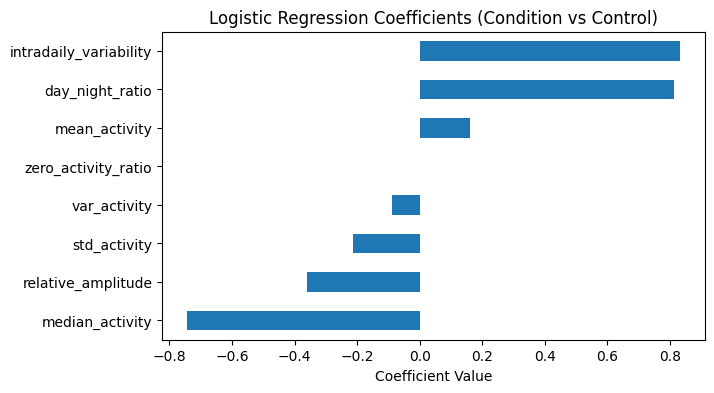

In [60]:
#step 6.2: Visualize model coefficients (Classification)
#Which features push predictions toward depression?
coef_clf.sort_values().plot(kind="barh", figsize=(7,4))
plt.title("Logistic Regression Coefficients (Condition vs Control)")
plt.xlabel("Coefficient Value")
plt.show()


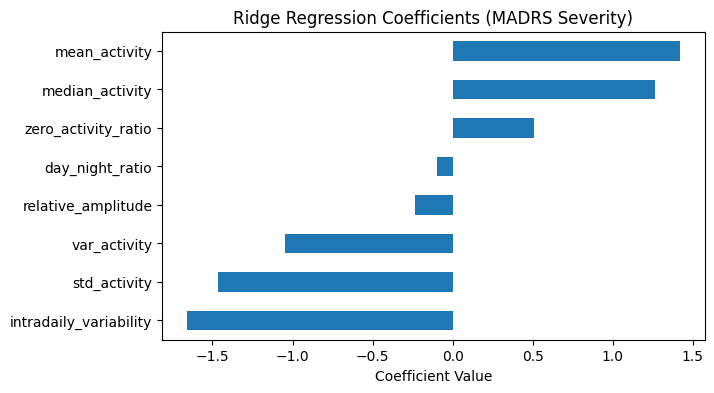

In [61]:
#step 6.3: Visualize regression coefficients
coef_reg.sort_values().plot(kind="barh", figsize=(7,4))
plt.title("Ridge Regression Coefficients (MADRS Severity)")
plt.xlabel("Coefficient Value")
plt.show()
